In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import draw

In [241]:
####################
# HELPER FUNCTIONS #
####################

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# Downloading MNIST data

We are again using the MNIST Data

In [26]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train._images.reshape(55000,784)
Y = mnist.train._labels
index = np.arange(55000)
np.random.shuffle(index)

train_bf = draw.BatchFeeder(X[index[:54000]], Y[index[:54000]], 128)
valid_bf = draw.BatchFeeder(X[index[54000:]], Y[index[54000:]], 128)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


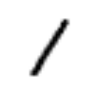

In [3]:
x, y = train_bf.next()
plt.figure(figsize=(1,1))
plt.imshow(x[0].reshape((28,28)), cmap='Greys')
plt.yticks([],[])
plt.xticks([],[])
plt.show()

# DRAW implementation

The code below implements this. https://arxiv.org/pdf/1502.04623.pdf

In [429]:
class DRAW:
    def __init__(self,
                 steps=10,
                 dims=[256, 256, 10],
                 batchsize=128,
                 width=28,
                 fn=tf.nn.elu,
                 attention = True,
                 dropout=1.0):
        # Reset all existing tensors
        tf.reset_default_graph()
        
        # Define parameters of the encoder
        self.dims = dims
        #self.fn = fn
        self.learning_rate = 0.001
        self._dropout = 1.0
        self.built = False
        self.sesh = tf.Session()
        self.e = 0
        self.steps = 10 
        self.batchsize = batchsize # default to 128
        self.attention = attention
        self.N = 5 # of filters.
        self.width = width
        self.inputsize = width**2 # default to 784 for MNIST
        self.epsilon = 1e-5        
        
        # Tracking data
        self.learning_curve = []
        self.record = {"cs":[], "y":[], "mu_x":[], "mu_y":[]}
        
        # Building the graph
        self.ops = self.build()
        self.sesh.run(tf.global_variables_initializer())
    
    def build(self):
        if self.built:
            return -1
        else:
            self.built = True
            
        #########
        # MODEL #
        #########
        
        # Some placeholders to define inputs/parameters
        x = tf.placeholder(tf.float32, shape=[self.batchsize, self.inputsize], name="x")
        dropout = tf.placeholder(tf.float32, shape=[], name="dropout_keepprob")
        
        # Defining LSTM cells to be used as encoder/decoder 
        # Change this to have other kinds of reccurent cells.
        self.encoder = tf.contrib.rnn.LSTMCell(self.dims[0], state_is_tuple=True, activation=tf.nn.elu)
        self.decoder = tf.contrib.rnn.LSTMCell(self.dims[1], state_is_tuple=True, activation=tf.nn.elu)
        
        # Some initialization on states and inputs
        dec_output = tf.zeros((self.batchsize, self.dims[1])) #output from previous decoder
        enc_state = self.encoder.zero_state(self.batchsize, tf.float32) # initial state for encoder
        dec_state = self.decoder.zero_state(self.batchsize, tf.float32) # initial state for decoder
        
        # Some lists to keep track of output and latent tensors
        canvases = [] # keeps track the current state of canvas
        mus = [] # keeps tracks of mus of latent distributions
        logsigmas = [] # keeps tracks of log(sigmas) of latent distributions
        
        reuse = None
        # Unrollinng the whole graph
        mu_xs = []
        mu_ys = []
        for i in range(self.steps):
            # If it is first iteration, start with brand new canvas
            if i == 0:
                prev_canvas = tf.zeros((self.batchsize, self.inputsize))
            else:
                prev_canvas = canvases[-1]

            # Calculate the residual in the image
            x_hat = x - tf.nn.sigmoid(prev_canvas)
            
            # read input depends on input shape
            if self.attention: 
                _input = self.read_with_attention(x, x_hat, dec_output, reuse=reuse)
            else:
                _input = tf.concat([x, x_hat, dec_output], axis=1)
                
            
            # Apply an encoder to it using appropriate reuse term
            enc_output, enc_state = self.encode(_input, enc_state, reuse=reuse)
            
            # Sampling 
            with tf.variable_scope("sampling", reuse=reuse):
                z_mean = tf.contrib.slim.fully_connected(enc_output, self.dims[-1], activation_fn=tf.identity, scope="mean")
                z_logsigma = tf.contrib.slim.fully_connected(enc_output, self.dims[-1], activation_fn=tf.identity, scope="sigma")
                mus.append(z_mean)
                logsigmas.append(z_logsigma)
            
            z = self.sample(z_mean, z_logsigma)
            
            # Apply an decoder to latent values.
            dec_output, dec_state = self.decode(z, dec_state, reuse=reuse)
            
            # Apply linear transfromation to dec_output and add to canvas
            if self.attention:
                temp, mu_x, mu_y = self.write_with_attention(dec_output, reuse)
                cur_canvas = prev_canvas + temp
                mu_xs.append(mu_x)
                mu_ys.append(mu_y)
            else:
                cur_canvas = prev_canvas + tf.contrib.slim.fully_connected(dec_output,\
                                                                           self.inputsize,\
                                                                           activation_fn=tf.identity,\
                                                                           scope="writing",\
                                                                           reuse=reuse)
            # Add to canvas
            canvases.append(cur_canvas) 
            
            # Keep reusing the first weights built.
            reuse = True
            
        reconstructed = tf.nn.sigmoid(canvases[-1])
            
        ########
        # LOSS #
        ########
        
        # Defining reconstruction loss
        rec_loss = self.crossEntropy(reconstructed, x)
        
        kl_holder = []
        # Defining KL loss
        for i in range(self.steps):
            kl_holder.append(self.kullbackLeibler(mus[i], logsigmas[i]))
        kl_loss = tf.add_n(kl_holder)
        
        with tf.name_scope("cost"):
            # average over minibatch
            cost = tf.reduce_mean(rec_loss + kl_loss, name="draw_cost")
            
        ################
        # OPTIMIZATION #
        ################
        
        # Defining optimization procedure.
        with tf.name_scope("Adam_optimizer"):
            optimizer = tf.train.AdamOptimizer(self.learning_rate)
            tvars = tf.trainable_variables()
            grads_and_vars = optimizer.compute_gradients(cost, tvars)
            # Gradient clipping here.
            clipped = [(tf.clip_by_value(grad, -5, 5), tvar) for grad, tvar in grads_and_vars]
            train = optimizer.apply_gradients(clipped, name="minimize_cost")
            
        ############
        # SAMPLING # 
        ############
        zs_ = [tf.placeholder_with_default(tf.random_normal([self.batchsize, self.dims[-1]]),
                                            shape=[self.batchsize, self.dims[-1]],
                                            name="latent_input") for _ in range(self.steps)]
        dec_state = self.decoder.zero_state(self.batchsize, tf.float32) # initial state for decoder
        cs_ = []
        mu_xs_ = []
        mu_ys_ = []
        for i in range(self.steps):
            if i == 0:
                prev_canvas = tf.zeros((self.batchsize, self.inputsize))
            else:
                prev_canvas = cs_[-1]
            dec_output, dec_state = self.decode(zs_[i], dec_state, reuse=True)
            if self.attention:
                temp, mu_x, mu_y = self.write_with_attention(dec_output, reuse)
                cur_canvas = prev_canvas + temp
                mu_xs_.append(mu_x)
                mu_ys_.append(mu_y)
            else:
                cur_canvas = prev_canvas + tf.contrib.slim.fully_connected(dec_output,\
                                                                           self.inputsize,\
                                                                           activation_fn=tf.identity,\
                                                                           scope="writing",\
                                                                           reuse=True)
            cs_.append(cur_canvas)
        
            
        # Exporting out the operaions as dictionary
        return dict(
            dropout_keepprob = dropout,
            x = x,  
            z_mean = z_mean, 
            z_logsigma = z_logsigma,
            latent_input = zs_,
            reconstructed = canvases,
            reconstructed_ = cs_,
            mu_xs = mu_xs,
            mu_ys = mu_ys,
            mu_xs_ = mu_xs_,
            mu_ys_ = mu_ys_,
            rec_loss = rec_loss,
            kl_loss = kl_loss,
            cost = cost,
            train = train
        )
    
    # Filter bank takes linear combination of h_dec as these values.
    def filterbank(self, gx, gy, sigma2, delta):
        # Create a range of float to make points with. This is 1 by 5 tensor
        grid_i = tf.reshape(tf.cast(tf.range(self.N), tf.float32), [1, -1])
        
        # Figure out the center (mean location of filters: 128 by 5 
        mu_x = gx + (grid_i - self.N / 2 - 0.5) * delta # Equation 19
        mu_y = gy + (grid_i - self.N / 2 - 0.5) * delta # Equation 20
        
        # This creates an matrix of size 1 by 1 by 28.
        # The number contained in here is just [0,1,2,3,4,5,6....,28]
        a = tf.reshape(tf.cast(tf.range(self.width), tf.float32), [1, 1, -1])
        b = tf.reshape(tf.cast(tf.range(self.width), tf.float32), [1, 1, -1])
        
        # Reshaping of the above mean locations.
        mu_x = tf.reshape(mu_x, [-1, self.N, 1])
        mu_y = tf.reshape(mu_y, [-1, self.N, 1])
        
        # 128 by 5 by 28 for Fx and 128 x 1 x1 for sigma
        sigma2 = tf.reshape(sigma2, [-1, 1, 1])
        Fx = tf.exp(-tf.square((a - mu_x) / (2*sigma2))) # Equation 25
        Fy = tf.exp(-tf.square((b - mu_y) / (2*sigma2))) # Equation 26
        
        # normalize, sum over A and B dims
        # the keeps_sum option retains the sqaushed dimension as length 1.
        Fx = Fx/tf.maximum(tf.reduce_sum(Fx,2,keep_dims=True), self.epsilon) # Equation 25 normalization
        Fy = Fy/tf.maximum(tf.reduce_sum(Fy,2,keep_dims=True), self.epsilon) # Equation 26 normalization
        return Fx, Fy, mu_x, mu_y

    # creates attention window with given parameters.
    # Returns filter to be applied (128, 5, 28)
    def attn_window(self, scope, dec_output, reuse):
        
        # create attention window with different scopes.
        with tf.variable_scope(scope, reuse=reuse):
            params=tf.contrib.slim.fully_connected(dec_output, 5, activation_fn=tf.identity, scope=scope, reuse=reuse)
            
        # Split the result of dense connection
        gx_, gy_, log_sigma2, log_delta, log_gamma=tf.split(params,5,1)
        
        # figure out the center location of guassian filter.
        # I am concerned that gx might just go out of boundary?
        # Makes more sense to do tanh transformation on gx_ and gy_?
        gx = (self.width+1)/2*(gx_+1) # Equation 22
        gy = (self.width+1)/2*(gy_+1) # Equation 23
        
        # both sigma and gamma is in [0, inf] range.
        sigma2 = tf.exp(log_sigma2)
        gamma = tf.exp(log_gamma)
        
        # figuring out the offset from center.
        delta=(self.width-1)/(self.N-1)*tf.exp(log_delta) # Equation 24
        
        return self.filterbank(gx,gy,sigma2,delta)+(gamma,)
    
    # read with attention 
    def read_with_attention(self, x, x_hat, dec_output, reuse):
        Fx, Fy, _, _, gamma = self.attn_window("read", dec_output, reuse=reuse)
        
        # the function below implements Equation 27
        def filter_img(img,Fx,Fy,gamma,N):
            Fxt = tf.transpose(Fx, perm=[0,2,1])
            img = tf.reshape(img,[-1, self.width, self.width])
            glimpse = tf.matmul(Fy,tf.matmul(img, Fxt))
            glimpse = tf.reshape(glimpse,[-1,N*N])
            return glimpse*tf.reshape(gamma,[-1,1])
        
        x = filter_img(x, Fx, Fy, gamma, self.N)
        x_hat = filter_img(x_hat, Fx, Fy, gamma, self.N)
        return tf.concat([x, x_hat, dec_output], 1)
    
    # write with attention
    def write_with_attention(self, dec_output, reuse):
        # Apply linear transfromation to figure out the parameters. 
        with tf.variable_scope("writeW", reuse=reuse):
            w = tf.contrib.slim.fully_connected(dec_output, self.N**2, activation_fn=tf.identity, scope="writeW", reuse=reuse)
        
        # Create 128 by 5 by 5 image.
        w = tf.reshape( w, [self.batchsize, self.N, self.N])
        Fx, Fy, mu_x, mu_y, gamma= self.attn_window("write", dec_output, reuse=reuse)
        
        # Implementing equation 28
        Fyt = tf.transpose(Fy, perm=[0,2,1])
        wr = tf.matmul(Fyt,tf.matmul(w, Fx))
        wr = tf.reshape(wr, [self.batchsize, self.width**2])
        
        # Gamma is applied at the end to produce 128 by 784 vector.
        return wr*tf.reshape(1.0/gamma,[-1,1]), mu_x, mu_y

    # Defines a encoder graph
    def encode(self, _input, state, reuse=None):
        with tf.variable_scope("encoder",reuse = reuse):
            # state_is_tuple shouldnt be necessary if you are using modern tensorflow modules.
            return self.encoder(_input, state)
        
    # Defines a decoder graph
    def decode(self, _input, state, reuse=None):
        with tf.variable_scope("decoder", reuse = reuse):
            return self.decoder(_input, state)

    # ReparameterizationTrick
    def sample(self, mu, log_sigma):
        with tf.name_scope("sample_reparam"):
            epsilon = tf.random_normal(tf.shape(log_sigma), name="0mean1varGaus")
            return mu + epsilon * tf.exp(log_sigma)

    # Binary cross-entropy (Adapted from online source)
    def crossEntropy(self, obs, actual, offset=1e-7):
        with tf.name_scope("BinearyXent"):
            obs_ = tf.clip_by_value(obs, offset, 1 - offset)
            return -tf.reduce_sum(actual * tf.log(obs_) +
                                  (1 - actual) * tf.log(1 - obs_), 1)
        
    # KL divergence between Gaussian with mu and log_sigma, q(z|x) vs 0-mean 1-variance Gaussian p(z).
    def kullbackLeibler(self, mu, log_sigma):
        with tf.name_scope("KLD"):
            return -0.5 * tf.reduce_sum(1 + 2 * log_sigma - mu**2 - tf.exp(2 * log_sigma), 1)
        
    # training procedure.
    def train(self, X, epochs, valid=None):
        # Making the saver object.
        saver = tf.train.Saver()
        
        # Defining the number of batches per epoch
        batch_num = int(np.ceil(X.n*1.0/X.batch_size))
        if valid != None:
            val_batch_num = int(np.ceil(valid.n*1.0/valid.batch_size))
        
        e = 0
        while e < epochs:
            
            epoch_cost = {"kld":[], "rec":[], "cost":[], "validcost":[]}
            if e == epochs-1: self.record = {"cs":[], "y":[], "mu_x":[], "mu_y":[]}
            
            for i in range(batch_num):
                #Training happens here.
                batch = X.next()
                feed_dict = {self.ops["x"]: batch[0], self.ops["dropout_keepprob"]: self._dropout}
                ops_to_run = [self.ops["cost"], self.ops["kl_loss"], self.ops["rec_loss"], self.ops["train"]]
                cost, kld, rec, _= self.sesh.run(ops_to_run, feed_dict)
                
                #if e == epochs-1: 
                if True:
                    canvas = self.sesh.run(self.ops["reconstructed"], feed_dict)
                    canvas = np.stack(canvas, axis=-1)
                    mux = self.sesh.run(self.ops["mu_xs"], feed_dict)
                    mux = np.stack(mux, axis=-1)
                    muy = self.sesh.run(self.ops["mu_ys"], feed_dict)
                    muy = np.stack(muy, axis=-1)
                    self.record["cs"] = self.record["cs"] + [_ for _ in canvas]
                    self.record["y"] = self.record["y"] + [_ for _ in batch[1]]
                    self.record["mu_x"] = self.record["mu_x"] + [_ for _ in mux]
                    self.record["mu_y"] = self.record["mu_y"] + [_ for _ in muy]
                    
                epoch_cost["kld"].append(np.mean(kld))
                epoch_cost["rec"].append(np.mean(rec))
                epoch_cost["cost"].append(cost)
            
            if valid != None:
                for i in range(val_batch_num):
                    batch = valid.next()
                    feed_dict = {self.ops["x"]: batch[0], self.ops["dropout_keepprob"]: 1.0}
                    cost = self.sesh.run(self.ops["cost"], feed_dict)
                    epoch_cost["validcost"].append(cost)
            self.e+=1
            e+= 1
                
            print "Epoch:"+str(self.e), "train_cost:", np.mean(epoch_cost["cost"]),
            if valid != None: print "valid_cost:", np.mean(epoch_cost["validcost"]),
            print "(", np.mean(epoch_cost["kld"]), np.mean(epoch_cost["rec"]), ")"
            self.learning_curve.append(epoch_cost)
            
    # Decode latent examples. Other_wise, draw from N(0,1)
    def generate(self):
        feed_dict = {self.ops["dropout_keepprob"]: 1.0}
        canvas = self.sesh.run(self.ops["reconstructed_"], feed_dict)
        canvas = np.stack(canvas, axis=-1)
        mux = self.sesh.run(self.ops["mu_xs_"], feed_dict)
        mux = np.concatenate(mux, axis=2)
        muy = self.sesh.run(self.ops["mu_ys_"], feed_dict)
        muy = np.concatenate(muy, axis=2)
        return canvas, mux, muy

# Tranining a model without attention mechanism.

In [ ]:
model = DRAW(15)

In [ ]:
# Seems like it overfits within just 10 iterations?
model.train(train_bf, 60, valid_bf)

Epoch:1 train_cost: 210.838 valid_cost: 176.497 ( 5.57479 205.263 )
Epoch:2 train_cost: 160.26 valid_cost: 149.901 ( 11.6155 148.645 )
Epoch:3 train_cost: 142.172 valid_cost: 139.093 ( 16.9534 125.218 )
Epoch:4 train_cost: 131.263 valid_cost: 130.194 ( 20.3248 110.938 )
Epoch:5 train_cost: 124.71 valid_cost: 124.144 ( 21.8096 102.901 )
Epoch:6 train_cost: 120.674 valid_cost: 120.07 ( 22.7583 97.9161 )
Epoch:7 train_cost: 117.875 valid_cost: 118.283 ( 23.2267 94.6479 )
Epoch:8 train_cost: 115.537 valid_cost: 115.27 ( 23.4864 92.0504 )
Epoch:9 train_cost: 114.031 valid_cost: 113.814 ( 23.6247 90.4064 )
Epoch:10 train_cost: 112.105 valid_cost: 111.99 ( 23.6733 88.4313 )
Epoch:11 train_cost: 110.961 valid_cost: 111.325 ( 23.7791 87.1819 )
Epoch:12 train_cost: 109.779 valid_cost: 110.019 ( 23.7219 86.0575 )
Epoch:13 train_cost: 108.797 valid_cost: 109.345 ( 23.7777 85.019 )
Epoch:14 train_cost: 107.794 valid_cost: 107.778 ( 23.7624 84.0318 )
Epoch:15 train_cost: 106.877 valid_cost: 108.345 

# Plotting the drawing process

Iteratively reconstruct a sample given a real example

In [ ]:
index = np.random.randint(50000)
sample = model.record["cs"][index].reshape(28,28,10)
print "label:", np.argmax(model.record["y"][index])
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(sigmoid(sample[:,:,i]), vmin=0, vmax=1)
    plt.xticks([],[])
    plt.yticks([],[])
plt.show()

# Generating a random drawing sample

Iteratively generate a sample by drawing from a latent distribution at every step.

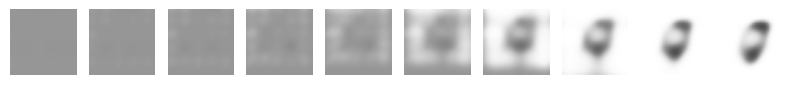

In [423]:
generated, mux, muy = model.generate()
index = -1
images = generated[index].reshape((28, 28, 10))

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(sigmoid(images[:,:,i]), vmin=0, vmax=1)
    plt.xticks([],[])
    plt.yticks([],[])
plt.show()

In [425]:
mux[0, :, 0]

array([  0.90965652,   6.58404922,  12.25844288,  17.93283653,  23.60722923], dtype=float32)

In [426]:
muy[0, :, 0]

array([ -0.69745922,   4.95803547,  10.61353016,  16.2690239 ,  21.92451859], dtype=float32)